# Training an Autoencoder with ResNet to do image similarity search

Data downloaded from [artificio](https://github.com/ankonzoid/artificio) and decoder was based on code from [ResNet-decoder](https://github.com/JiahongChen/ResNet-decoder)

In [57]:
import os
from os import path

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from torchvision import io


class AutoEncoderDataset(Dataset):
    def __init__(self, images_dir: str):
        self.image_paths: list[str] = self.__get_image_paths(images_dir)

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        image = io.read_image(img_path)
        image = image.float()
        image = image / 255
        label = image.clone()
        return image, label

    def __get_image_paths(self, images_dir: str) -> list[str]:
        """Returns a list containing the absolute path to each file inside the directory
        """
        file_paths = []
        dir_abs_route = path.abspath(images_dir)
        files = os.listdir(dir_abs_route)
        for file in files:
            abs_filename = path.join(dir_abs_route, file)
            file_paths.append(abs_filename)
        return sorted(file_paths)


def imshow(img):
    npimg = np.array(img)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def plot_images(dataset: AutoEncoderDataset, indices: list[int]):
    n = len(indices)
    _, axes = plt.subplots(ncols=n, nrows=1)
    for i in range(n):
        img = dataset[indices[i]][0]
        npimg = np.array(img)
        npimg = np.transpose(npimg, (1, 2, 0))
        image_name = path.basename(dataset.image_paths[indices[i]])
        axes[i].set_title(image_name)
        axes[i].imshow(npimg)
        axes[i].set_axis_off()
    plt.tight_layout()
    plt.show()



def print_loss_history(train_loss: list[float], val_loss: list[float]):
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training loss")
    plt.legend()
    plt.show()

In [58]:
from typing import Callable

import torch
from torch import Tensor
from torch.nn import BatchNorm2d, Conv2d, ConvTranspose2d, Identity, Module, ReLU, Sequential, Sigmoid, Upsample
from torchvision import models
from torchvision.models.resnet import ResNet


class DecoderBottleneck(Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        output_padding: int = 0,
        upsample: Module | None = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Callable[..., Module] | None = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.upsample layers upsample the input when stride != 1
        self.conv3 = conv1x1(planes * self.expansion, width)
        self.bn3 = norm_layer(planes)
        self.conv2 = conv3x3(width, width, stride, groups, dilation, output_padding)
        self.bn2 = norm_layer(width)
        self.conv1 = conv1x1(width, inplanes)
        self.bn1 = norm_layer(inplanes)
        self.relu = ReLU(inplace=True)
        self.upsample = upsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv3(x)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn1(out)
        if self.upsample is not None:
            identity = self.upsample(x)
        out += identity
        out = self.relu(out)

        return out


class ResNetDecoder(Module):
    def __init__(self, block, layers: list[int]):
        super().__init__()
        self._norm_layer = BatchNorm2d
        self.inplanes = 2048
        self.dilation = 1

        self.unsample = Upsample(size=7, mode="nearest")
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer1 = self._make_layer(block, 64, layers[0], output_padding = 0, last_block_dim=64)
        self.image_output = Sequential(
            ConvTranspose2d(64, 3, kernel_size=6, stride=1, padding=1, dilation=2),
            Sigmoid()
        )

    def forward(self, x):
        x = torch.unflatten(x, 1, (2048, 1, 1))
        x = self.unsample(x)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = self.image_output(x)
        return x

    def _make_layer(
        self,
        block,
        planes: int,
        blocks: int,
        stride: int = 1,
        output_padding: int = 1,
        last_block_dim: int = 0,
    ) -> Sequential:
        norm_layer = self._norm_layer
        upsample = None
        previous_dilation = self.dilation
        self.groups = 1
        self.base_width = 64
        layers = []
        self.inplanes = planes * block.expansion
        if last_block_dim == 0:
            last_block_dim = self.inplanes // 2
        if stride != 1 or self.inplanes != planes * block.expansion or output_padding == 0:
            upsample = Sequential(
                conv1x1(planes * block.expansion, last_block_dim, stride, output_padding),
                # norm_layer(planes * block.expansion),
                norm_layer(last_block_dim),)
        last_block = block(
                last_block_dim, planes, stride, output_padding, upsample, self.groups,
                self.base_width, previous_dilation, norm_layer)
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer))
        layers.append(last_block)
        return Sequential(*layers)


class ResNetAutoEncoder(Module):
    def __init__(self, pretrained_weights=None):
        super().__init__()
        encoder = models.resnet50(weights=pretrained_weights)
        encoder = self.__modify_classification_head_for_embeddings(encoder)
        self.encoder = encoder
        self.decoder = ResNetDecoder(DecoderBottleneck, [3, 6, 4, 3])

    def forward(self, x: Tensor, embedding_only: bool = True):
        x = self.encoder(x)
        if not embedding_only:
            x = self.decoder(x)
        return x

    def __modify_classification_head_for_embeddings(self, encoder: ResNet) -> ResNet:
        encoder.fc = Identity()
        return encoder


def conv1x1(in_planes: int, out_planes: int, stride: int = 1, output_padding: int = 0) -> Conv2d:
    """1x1 convolution"""
    return ConvTranspose2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False,
                           output_padding=output_padding)


def conv3x3(
        in_planes: int,
        out_planes: int,
        stride: int = 1,
        groups: int = 1,
        dilation: int = 1,
        output_padding: int = 0
        ) -> Conv2d:
    """3x3 convolution with padding"""
    return ConvTranspose2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        output_padding = output_padding,
        groups=groups,
        bias=False,
        dilation=dilation)

Loading dataset and visualizing a training sample

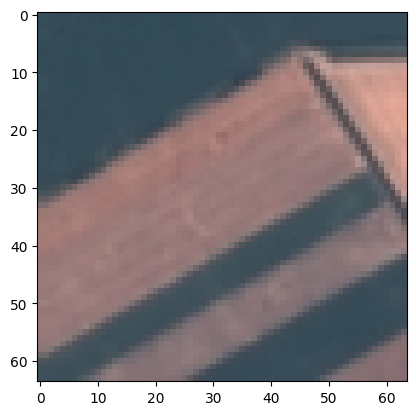

In [59]:
import random

from torch.utils.data import DataLoader

BATCH_SIZE = 16
DATA_DIR = "data/eurosat"

trainset = AutoEncoderDataset(f"{DATA_DIR}/train")
validationset = AutoEncoderDataset(f"{DATA_DIR}/validation")
testset = AutoEncoderDataset(f"{DATA_DIR}/test")
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_loader = DataLoader(validationset, batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
imshow(random.choice(trainset)[0])

### Query 1

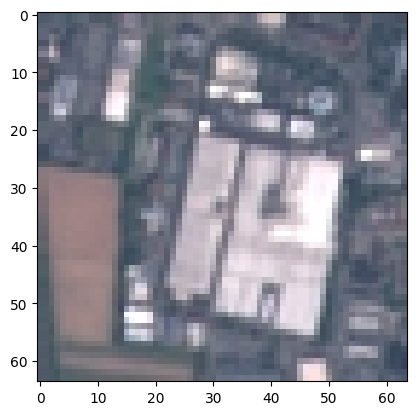

In [60]:
imshow(testset[8][0])

### Query 2

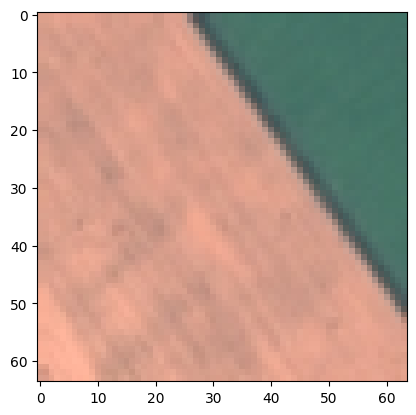

In [61]:
imshow(testset[1][0])

### Query 3

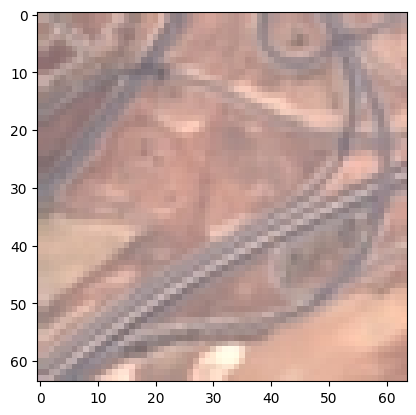

In [62]:
imshow(testset[7][0])

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Loading and predicting with pretrained encoder

In [64]:
from torchvision.models.resnet import ResNet50_Weights


autoencoder = ResNetAutoEncoder(pretrained_weights=ResNet50_Weights.IMAGENET1K_V1)
autoencoder = autoencoder.to(device)
print(autoencoder)

ResNetAutoEncoder(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


In [65]:
queries = []
autoencoder.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = autoencoder(images)
        queries.append(outputs[0].cpu())

In [66]:
from sklearn.neighbors import NearestNeighbors


image_embeddings = []
images = DataLoader(trainset, batch_size=1, shuffle=False, num_workers=2)
autoencoder.eval()
with torch.no_grad():
    for data in images:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = autoencoder(images)
        image_embeddings.append(outputs[0].cpu())
print(image_embeddings[0].shape)
print(image_embeddings[0])
neigh = NearestNeighbors(n_neighbors=5, algorithm="brute")
neigh.fit(image_embeddings)
distances, indices = neigh.kneighbors(queries)
print(indices)

torch.Size([2048])
tensor([0.0321, 0.0000, 0.0000,  ..., 0.0000, 0.2137, 0.5778])
[[15377 16350  6878 15625 15713]
 [  806   369  1909   348   948]
 [ 3463  3491  3488  3967 10187]
 [ 2904  6081 14227  3785  5400]
 [ 4914  5844  5776  6227  6256]
 [11199 12820  4836  4717  5031]
 [ 7480  6344  6809  7616  7561]
 [ 7654  7673  6436  6317  6745]
 [ 8106  9332  9008  9363  8352]
 [ 9489  9114 12843 10279 10522]
 [ 9822 10429  9941 10166 10767]
 [ 9871 11068 10342 10893 14091]
 [11575 11312 11461  1214 12290]
 [12827 12678 12395 12271 13481]
 [14857 14722 13882 13113 14901]
 [ 5552 14839 13103 13657  9611]
 [15796 16629 15824 16151 15525]
 [15547 15994  1419 10622    86]
 [16865 17426 17528 18019 17625]
 [17171 17228  2973 18321  4144]]


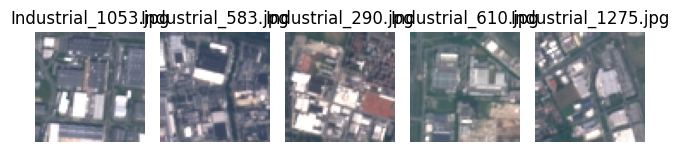

In [67]:
plot_images(trainset, indices[8])

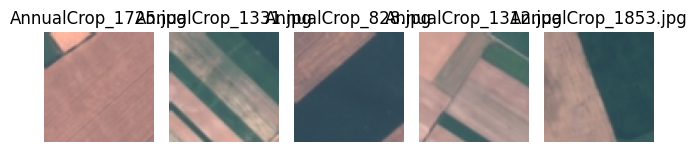

In [68]:
plot_images(trainset, indices[1])

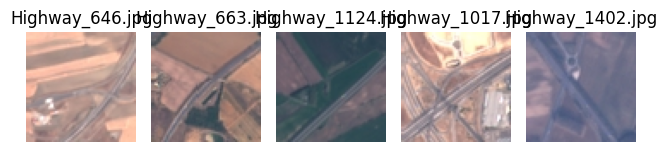

In [69]:
plot_images(trainset, indices[7])

## Training Autoencoder

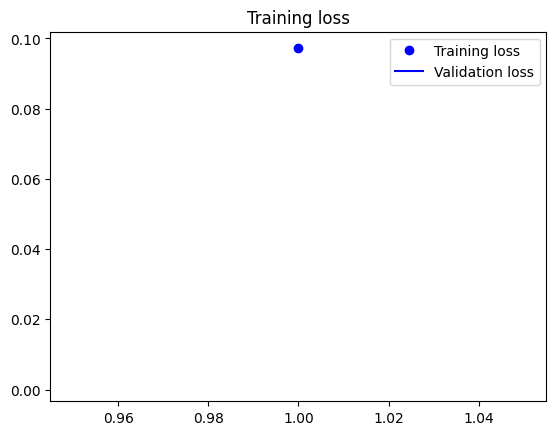

In [76]:
from torch.nn import MSELoss
from torch.optim import SGD


EPOCHS = 2
LEARNING_RATE = 0.00001

criterion = MSELoss()
optimizer = SGD(autoencoder.parameters(), lr=LEARNING_RATE, momentum=0.9)
train_loss = []
validation_loss = []
for epoch in range(1, EPOCHS + 1):
    running_loss = 0
    autoencoder.train()
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = autoencoder(images, False)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()
    val_loss = 0
    autoencoder.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = autoencoder(images, False)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss = val_loss / len(validation_loader)
    epoch_loss = running_loss / len(train_loader)
    train_loss.append(epoch_loss)
    validation_loss.append(val_loss)
print_loss_history(train_loss, validation_loss)

In [77]:
from sklearn.neighbors import NearestNeighbors


image_embeddings = []
images = DataLoader(trainset, batch_size=1, shuffle=False, num_workers=2)
autoencoder.eval()
with torch.no_grad():
    for data in images:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = autoencoder(images)
        image_embeddings.append(outputs[0].cpu())
print(image_embeddings[0].shape)
print(image_embeddings[0])
neigh = NearestNeighbors(n_neighbors=5, algorithm="brute")
neigh.fit(image_embeddings)
distances, indices = neigh.kneighbors(queries)
print(indices)

torch.Size([2048])
tensor([0.1581, 0.7947, 0.0000,  ..., 0.3735, 0.0884, 0.2365])
[[ 5869 14986 11823 17073  4919]
 [  948  4816  4794  5659  5491]
 [ 2701  3351  3594  6179  4111]
 [ 4111  2671  3351  2701 13929]
 [ 5372  4567  4855  3468  5790]
 [ 5473  5530  5502  4608  4391]
 [ 8165  8172  8247  8829  8622]
 [ 7333  6632 11869   452 11401]
 [ 9618  9598  8352  8146  9077]
 [11230  9114  8693  9753 12308]
 [10429 10273  2182 10997 10022]
 [ 2657  3623  3972  2756  4225]
 [12664 12577 10721 11441  1575]
 [ 9193  9334  9052  8215  9368]
 [14263 14020 14011 14921 13570]
 [14778 13955 13356 14794 14397]
 [ 9289  6984  8271  8026 15077]
 [ 1461  2802 14666   540  5473]
 [18444 18460 17236 18534 17972]
 [18503 17722 18873 17829 18032]]


In [78]:
queries = []
autoencoder.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = autoencoder(images)
        queries.append(outputs[0].cpu())

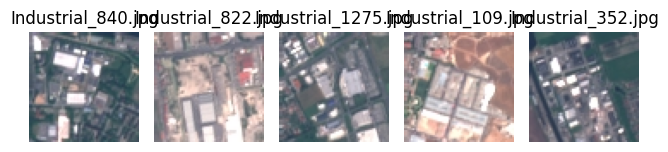

In [79]:
plot_images(trainset, indices[8])

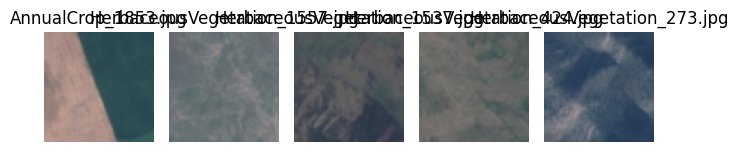

In [80]:
plot_images(trainset, indices[1])

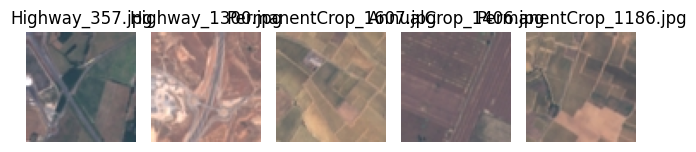

In [81]:
plot_images(trainset, indices[7])